### DETAILED EXPLANATION

This script generates blurred versions of each image in the dataset using three types of blur:

**Why Blurring Images?**

Blurring is a common type of image distortion that can occur due to various factors:

- Camera motion during capture (Motion Blur)
- Out-of-focus regions due to depth of field (Gaussian Blur)
- Uniform blurring due to poor image processing or resizing (Box Blur)

These blurs simulate real-world distortions, making our analysis more realistic.

**Types of Blur Used**

1. Gaussian Blur:
   - This blur applies a Gaussian kernel to each pixel, which results in a smooth, out-of-focus effect.
   - The blur is strongest at the center and gradually fades out (bell curve distribution).
   - We chose sigma range (0.5 to 3.0) because it provides visible but controlled blur.
   - Sigma defines the standard deviation of the Gaussian distribution (higher = stronger blur).

2. Motion Blur:
   - Simulates the effect of movement, either from a moving object or a moving camera.
   - The blur has a clear direction (angle) and intensity (length).
   - We chose length (5 to 30) to allow visible motion but not too extreme.
   - Angle (0 to 180) provides all possible directions of movement.

3. Box Blur:
   - Applies a simple averaging of pixel values in a square region around each pixel.
   - This blur is fast and commonly used for quick blur effects.
   - We chose kernel size (3 to 15) because it provides a visible blur without being too extreme.
   - The kernel size defines the square region used for averaging (higher = stronger blur).

**Why Save Parameters in a Parquet File?**

- Parquet is optimized for speed and storage efficiency.
- It is suitable for large datasets, ensuring fast read and write operations.
- Parquet allows us to store the blur parameters alongside the image identifiers, making it easy to track and analyze.

In [19]:
import sys
sys.path.append("../..")

In [20]:
import numpy as np
import cv2

def gen_gaussian_kernel(size, sigma):
    """Generate a Gaussian blur kernel."""
    k1d = cv2.getGaussianKernel(size, sigma)
    kernel = k1d @ k1d.T
    return kernel

def gen_motion_kernel(size, length, angle):
    """Generate a motion blur kernel based on length and angle."""
    kernel = np.zeros((size, size), dtype=np.float32)
    center = (size - 1) / 2

    angle_rad = np.deg2rad(angle)
    dx = length / 2 * np.cos(angle_rad)
    dy = length / 2 * np.sin(angle_rad)

    start_point = (int(center - dx), int(center - dy))
    end_point = (int(center + dx), int(center + dy))
    
    cv2.line(kernel, start_point, end_point, 1, 1)
    kernel /= np.sum(kernel)
    return kernel

def gen_box_kernel(size):
    """Generate a box blur kernel."""
    return np.ones((size, size), dtype=np.float32) / (size * size)

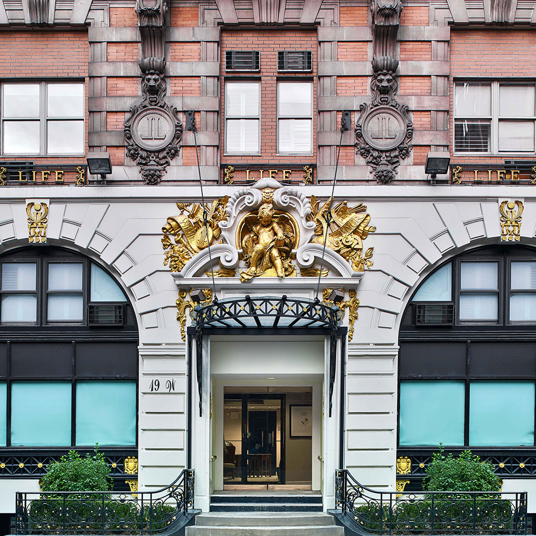

100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Blur generation completed.


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import utils.constants as const

# Parametri per il sample: None per tutte le immagini, oppure un intero per un subset
SAMPLE_SIZE = 10

ORIGINAL_DIR = const.ORIGINAL_DATASET_PATH / "00000"
image_files = sorted(list(ORIGINAL_DIR.glob("*.png")))

if SAMPLE_SIZE is not None:
    image_files = image_files[:SAMPLE_SIZE]

# Visualizza una delle immagini per controllo
if len(image_files) > 3:
    image = Image.open(image_files[3])
    display(image.resize((image.width // 2, image.height // 2)))

BLUR_TYPES = ['gaussian', 'motion', 'box']
for blur_type in BLUR_TYPES:
    (const.BLURRED_DATASET_PATH / blur_type).mkdir(parents=True, exist_ok=True)

PARAM_RANGES = {
    'gaussian': {'sigma': (0.5, 3.0)},
    'motion': {'length': (5, 30), 'angle': (0, 180)},
    'box': {'kernel_size': (3, 15)}
}

blurred_images = []

for img_path in tqdm(image_files):
    image = cv2.imread(str(img_path))
    if image is None:
        continue
    original_name = img_path.name

    for blur_type in BLUR_TYPES:
        if blur_type == 'gaussian':
            sigma = random.uniform(*PARAM_RANGES['gaussian']['sigma'])
            ksize = int(6 * sigma) | 1
            kernel = gen_gaussian_kernel(ksize, sigma)
            blurred = cv2.filter2D(image, -1, kernel)
            blur_params = {
                'gaussian_sigma': sigma,
                'gaussian_size': ksize
            }
        elif blur_type == 'motion':
            length = random.randint(*PARAM_RANGES['motion']['length'])
            angle = random.uniform(*PARAM_RANGES['motion']['angle'])
            ksize = length | 1
            kernel = gen_motion_kernel(ksize, length, angle)
            blurred = cv2.filter2D(image, -1, kernel)
            blur_params = {
                'motion_length': length,
                'motion_angle': angle,
                'motion_size': ksize
            }
        else:  # box
            kernel_size = random.randint(*PARAM_RANGES['box']['kernel_size'])
            kernel = gen_box_kernel(kernel_size)
            blurred = cv2.filter2D(image, -1, kernel)
            blur_params = {
                'box_size': kernel_size
            }

        blur_params.update({'image': original_name, 'blur_type': blur_type})
        blurred_images.append(blur_params)
        cv2.imwrite(str(const.BLURRED_DATASET_PATH / blur_type / original_name), blurred)

df_blur = pd.DataFrame(blurred_images)
df_blur.to_parquet(str(const.DIR_DATASET_PATH / "image_deblurring_performance_analysis_blur_metadata.parquet"), index=False)

print("Blur generation completed.")

In [22]:
df_blur

,gaussian_sigma,gaussian_size,image,blur_type,motion_length,motion_angle,motion_size,box_size
0,2.973942,17.0,000000000.png,gaussian,NaN,NaN,NaN,NaN
1,NaN,NaN,000000000.png,motion,30.0,92.762129,31.0,NaN
2,NaN,NaN,000000000.png,box,NaN,NaN,NaN,14.0
3,0.551659,3.0,000000002.png,gaussian,NaN,NaN,NaN,NaN
4,NaN,NaN,000000002.png,motion,30.0,86.595601,31.0,NaN
5,NaN,NaN,000000002.png,box,NaN,NaN,NaN,6.0
6,1.585039,9.0,000000003.png,gaussian,NaN,NaN,NaN,NaN
7,NaN,NaN,000000003.png,motion,9.0,55.705648,9.0,NaN
8,NaN,NaN,000000003.png,box,NaN,NaN,NaN,7.0
9,2.559760,15.0,000000004.png,gaussian,NaN,NaN,NaN,NaN


In [23]:
df_original = pd.read_parquet(str(const.DIR_DATASET_PATH / "image_deblurring_dataset.parquet"))
df_original

,url,category,key,width,height,exif,aspect_ratio,size
0,http://100500foto.com/wp-content/uploads/2016/...,people,None,NaN,NaN,None,NaN,NaN
1,http://2gfsl7am0og1m91u0pwpiehl.wpengine.netdn...,indoor_scene,None,NaN,NaN,None,NaN,NaN
2,http://411posters.com/wp-content/uploads/2011/...,poster,000000382,1300.0,1728.0,{},0.752315,3169036.0
3,http://RealEstateAdminImages.gabriels.net/170/...,architecture,None,NaN,NaN,None,NaN,NaN
4,http://RealEstateAdminImages.gabriels.net/170/...,architecture,None,NaN,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...,...
1245,https://www.yamaha.com/en/musical_instrument_g...,complex,000000564,1800.0,1042.0,{},1.727447,3199285.0
1246,https://www.yellowmaps.com/usgs/topomaps/drg24...,map,000001225,1509.0,2026.0,"{""Image Tag 0x5100"": ""0""}",0.744817,5742001.0
1247,https://www.zappos.com/images/z/2/5/1/8/8/7/25...,furniture,000000481,1920.0,1440.0,{},1.333333,4276346.0
1248,https://ycdn.space/h/2015/02/Capitol-Hill-Loft...,indoor_scene,000000954,1050.0,1575.0,{},0.666667,2000861.0


In [24]:
df_blur['key'] = df_blur['image'].str.replace('.png', '', regex=False)
df_blur

,gaussian_sigma,gaussian_size,image,blur_type,motion_length,motion_angle,motion_size,box_size,key
0,2.973942,17.0,000000000.png,gaussian,NaN,NaN,NaN,NaN,000000000
1,NaN,NaN,000000000.png,motion,30.0,92.762129,31.0,NaN,000000000
2,NaN,NaN,000000000.png,box,NaN,NaN,NaN,14.0,000000000
3,0.551659,3.0,000000002.png,gaussian,NaN,NaN,NaN,NaN,000000002
4,NaN,NaN,000000002.png,motion,30.0,86.595601,31.0,NaN,000000002
5,NaN,NaN,000000002.png,box,NaN,NaN,NaN,6.0,000000002
6,1.585039,9.0,000000003.png,gaussian,NaN,NaN,NaN,NaN,000000003
7,NaN,NaN,000000003.png,motion,9.0,55.705648,9.0,NaN,000000003
8,NaN,NaN,000000003.png,box,NaN,NaN,NaN,7.0,000000003
9,2.559760,15.0,000000004.png,gaussian,NaN,NaN,NaN,NaN,000000004


In [26]:
# Pivot per avere una sola riga per ogni key, con colonne per ogni tipo di blur
df_blur_pivot = df_blur.pivot_table(
    index='key',
    values=[
        'gaussian_sigma', 'gaussian_size',
        'motion_length', 'motion_angle', 'motion_size',
        'box_size'
    ],
    aggfunc='first'
).reset_index()

# Merge LEFT per mantenere tutte le righe di df_original
df_merged = pd.merge(
    df_original,
    df_blur_pivot,
    on='key',
    how='left'
)

# Seleziona solo le colonne richieste
final_columns = [
    'url', 'category', 'key', 'width', 'height', 'exif', 'aspect_ratio', 'size',
    'gaussian_sigma', 'gaussian_size',
    'motion_length', 'motion_angle', 'motion_size',
    'box_size'
]
df_final = df_merged[final_columns]

# Mostra solo le prime 20 key (righe con key non nulla), ordinate per key
#df_final[df_final['key'].notnull()].sort_values('key').head(10)
df_final

,url,category,key,width,height,exif,aspect_ratio,size,gaussian_sigma,gaussian_size,motion_length,motion_angle,motion_size,box_size
0,http://100500foto.com/wp-content/uploads/2016/...,people,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,http://2gfsl7am0og1m91u0pwpiehl.wpengine.netdn...,indoor_scene,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,http://411posters.com/wp-content/uploads/2011/...,poster,000000382,1300.0,1728.0,{},0.752315,3169036.0,NaN,NaN,NaN,NaN,NaN,NaN
3,http://RealEstateAdminImages.gabriels.net/170/...,architecture,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,http://RealEstateAdminImages.gabriels.net/170/...,architecture,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,https://www.yamaha.com/en/musical_instrument_g...,complex,000000564,1800.0,1042.0,{},1.727447,3199285.0,NaN,NaN,NaN,NaN,NaN,NaN
1246,https://www.yellowmaps.com/usgs/topomaps/drg24...,map,000001225,1509.0,2026.0,"{""Image Tag 0x5100"": ""0""}",0.744817,5742001.0,NaN,NaN,NaN,NaN,NaN,NaN
1247,https://www.zappos.com/images/z/2/5/1/8/8/7/25...,furniture,000000481,1920.0,1440.0,{},1.333333,4276346.0,NaN,NaN,NaN,NaN,NaN,NaN
1248,https://ycdn.space/h/2015/02/Capitol-Hill-Loft...,indoor_scene,000000954,1050.0,1575.0,{},0.666667,2000861.0,NaN,NaN,NaN,NaN,NaN,NaN
